# 03 - Modelo final de corrección de irradiancia (XGBoost)

## 1. Resumen  

En este cuaderno se implementa el entrenamiento del modelo de predicción de irradiancia solar, desarrollado en el marco del TFG **Modelización de la irradiancia solar en sistemas fotovoltaicos con motores de videojuegos**.  

El objetivo es modelar los fenómenos atmosféricos complejos (nubosidad, aerosoles, vapor de agua) que el motor de renderizado no contempla por sí mismo. Para ello, se entrena un modelo **XGBoost** que estima un **factor de corrección multiplicativo** \(k\), de modo que:  

`irr_real = k * irr_simulada`

El factor de corrección se define como:  

`k = irr_real / (irr_sim + e)`  

El término `e` se introduce para evitar divisiones por cero cuando irr_sim ≈ 0 y mejorar la estabilidad.  

El modelo se entrena a partir del dataset `dataset_master_tfg.csv`, que integra:  
- Variables geométricas y de visibilidad solar obtenidas a partir de la simulación en Unreal Engine, incluyendo la irradiancia virtual normalizada. 
- Variables atmosféricas externas obtenidas a través del servicio de Solcast. 
- Medidas reales de irradiancia registradas por los piranómetros.  

Para la evaluación, se han seleccionado tres días (`2025-04-11`, `2025-04-20` y `2025-10-07`) como conjunto de test, los cuáles se excluyen del entrenamiento. Cada uno de los días representa un caso modelo de régimen atmosférico (cubierto, variable y despejado). Resulta de especial interés el día `2025-10-07`, debido a la presencia de sombras proyectadas sobre el sensor P1. 

El resultado final de este cuaderno es el modelo entrenado, almacenado como `model_final.pkl`, junto con los metadatos asociados a su configuración y rendimiento.  

## 2. Configuración del entrenamiento

### 2.1 Entorno y librerías

In [14]:
import os, json, hashlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
import warnings

from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_absolute_error

warnings.simplefilter(action='ignore', category=FutureWarning)

### 2.2 Configuración del entrenamiento

In [15]:
CFG_FINAL = {
    "iteration_id": "final_model",
    "data_path": "../data/dataset_master_tfg.csv",
    "description": 
        """
    La mejor configuración para el modelo minimal.
        """,
    
    # Target definition
    "target": "k_eff",
    "k_clip": (0.0, 1.5),
    "sim_clip_lower": 1.0,
    "eps": 10.0,
    
    # Split
    "test_dates": ["2025-04-11", "2025-04-20", "2025-10-07"],
    "train_filter": {
       "min_altitude_deg": 5.0,
    },
    
    # Features
    "feature_sets": {
        "final": [
            # --- minimal ---
            "sim_irradiance_wm2",
            "cloud_opacity",

        ],
    },
    "feature_set_name": "final",
    
    # Model
    "model_params": dict(
        n_estimators=800,
        learning_rate=0.01,
        max_depth=4,
        min_child_weight=70,
        subsample=0.5,
        colsample_bytree=0.5,
        reg_alpha=0.1,
        reg_lambda=1.0,
        gamma=0.1,
        objective="reg:squarederror",
        eval_metric="rmse",
        n_jobs=-1,
        random_state=42,
    ),
    
    # Outputs
    "out_dir" : "../artifacts",
    "out_iterations": "../artifacts/iterations",
    "out_predictions": "../artifacts/predictions",
    "out_final": "../artifacts/final_model",
    
}

## 3. Carga y preparación de datos

In [16]:
def load_base_df(path):
    df = pd.read_csv(path)
    
    # Timestamp index
    df["timestamp"] = pd.to_datetime(df["Unnamed: 0"])
    df = df.set_index("timestamp").drop(columns=["Unnamed: 0"])
    
    # Bool->int 
    for c in [c for c in df.columns if df[c].dtype == bool]:
        df[c] = df[c].astype(int)
    df["date"] = df["date"].astype(str)
    
    return df

In [17]:
def split_train_test(df, cfg):
    test_df = df[df["date"].isin(cfg["test_dates"])].copy()
    train_df = df[~df["date"].isin(cfg["test_dates"])].copy()

    # Train filtering by solar altitude
    min_alt = cfg["train_filter"].get("min_altitude_deg", 0)
    if "sim_altitude" in train_df.columns:
        train_df = train_df[train_df["sim_altitude"] > min_alt].copy()
    
    # Clean NaNs 
    train_df = train_df.dropna(subset=["real_irradiance", "sim_irradiance_wm2", "cloud_opacity"])
    
    return train_df, test_df

In [18]:
def fingerprint_config(cfg):
    # Hash to identify iterations
    raw = json.dumps(cfg, sort_keys=True).encode("utf-8")
    return hashlib.md5(raw).hexdigest()[:10]

## 4. Construcción del vector de características

In [19]:
def add_features(df, cfg):
    df = df.copy()
    df = df.sort_index()

    # --- CUSTOM FEATURES --- 
    
    # diffuse fraction
    sim_diffuse_wm2 = 0.01305 * df["sim_comp_amb_lux"]
    df["sim_diffuse_fraction"] = sim_diffuse_wm2 / (df['sim_irradiance_wm2'] + 1.0)
    df["sim_diffuse_fraction"] = df["sim_diffuse_fraction"].clip(0.0, 1.0)
    df["sim_diffuse_fraction"] = df["sim_diffuse_fraction"].fillna(0.0)
   
    # Temporal window
    s = df.groupby(df.index)["cloud_opacity"].first().sort_index()
    
    window = "60T"
    window_10 = 5   # 5 * 2min = 10 min
    window_20 = 10  # 10 * 2min = 20 min
    s_mean_10 = s.rolling(window_10, min_periods=1).mean()
    s_std_10  = s.rolling(window_10, min_periods=1).std().fillna(0)

    s_mean_20 = s.rolling(window_20, min_periods=1).mean()
    s_std_20  = s.rolling(window_20, min_periods=1).std().fillna(0)
    
    s_mean_60 = s.rolling(window, min_periods=1).mean()
    s_std_60  = s.rolling(window, min_periods=1).std().fillna(0)
    s_diff = s.diff().fillna(0)

    s_lag_1 = s.shift(1)
    s_lag_2 = s.shift(2)

    # --- Deltas ---
    s_delta_1 = s - s_lag_1
    s_delta_2 = s - s_lag_2
    
    for series in [s_lag_1, s_lag_2, s_delta_1, s_delta_2]:
        series.fillna(0, inplace=True)
    
    # Map back
    df["cloud_mean_60m"] = df.index.map(s_mean_60)
    df["cloud_std_60m"]  = df.index.map(s_std_60)

    df["cloud_mean_10m"] = df.index.map(s_mean_10)
    df["cloud_std_10m"]  = df.index.map(s_std_10)

    df["cloud_mean_20m"] = df.index.map(s_mean_20)
    df["cloud_std_20m"]  = df.index.map(s_std_20)

    df["cloud_opacity_lag_2m"] = df.index.map(s_lag_1)
    df["cloud_opacity_lag_4m"] = df.index.map(s_lag_2)

    df["cloud_delta_2m"] = df.index.map(s_delta_1)
    df["cloud_delta_4m"] = df.index.map(s_delta_2)

    # --------
    
    # Temporal interpolation of missing data (4 min max)
    df = df.interpolate(method="time", limit=2).ffill()

    # Dummies sensor
    df = pd.get_dummies(df, columns=["sensor"], prefix="sensor")
    return df

In [20]:
def build_feature_list(df, cfg):
    base = list(cfg["feature_sets"][cfg["feature_set_name"]])

    # Automatically add sensor_* columns
    sensor_cols = sorted([c for c in df.columns if c.startswith("sensor_")])
    feats = base #+ sensor_cols --> SENSORS NOT ADDED

    # Dedupe
    seen = set()
    feats = [f for f in feats if not (f in seen or seen.add(f))]
    return feats

## 5. Entrenamiento del modelo

In [21]:
def build_k_eff(df, cfg):
    eps = float(cfg["eps"])
    sim = df["sim_irradiance_wm2"].astype(float).values
    real = df["real_irradiance"].astype(float).values

    k = real / (sim + eps)

    lo, hi = cfg["k_clip"]
    k = np.clip(k, lo, hi)

    mask = sim >= float(cfg["sim_clip_lower"])
    return k, mask

In [22]:
def train_model(X_train, y_train, cfg):
    model = XGBRegressor(**cfg["model_params"])
    model.fit(X_train, y_train)
    return model

In [23]:
def predict_irradiance(model, df, X, cfg):
    # pred_k * sim_irradiance 
    sim = df["sim_irradiance_wm2"].astype(float).values
    k_pred = model.predict(X)

    lo, hi = cfg["k_clip"]
    k_pred = np.clip(k_pred, lo, hi)

    pred_irr = np.maximum(k_pred * sim, 0.0)
    return k_pred, pred_irr

In [24]:
def compute_metrics(y_true, y_pred):
    y_true = np.asarray(y_true, float)
    y_pred = np.asarray(y_pred, float)
    rmse = float(np.sqrt(np.mean((y_true - y_pred) ** 2)))
    return {
        "r2": float(r2_score(y_true, y_pred)),
        "mae": float(mean_absolute_error(y_true, y_pred)),
        "rmse": rmse,
        "mbe": float(np.mean(y_pred - y_true)),
    }

In [25]:
def extract_feature_importance(model, features, importance_type="gain"):
    """
    Extracts and returns feature importance as a sorted DataFrame.
    """
    booster = model.get_booster()
    score = booster.get_score(importance_type=importance_type)

    # Ensure all features appear
    data = []
    for f in features:
        data.append({
            "feature": f,
            "importance": float(score.get(f, 0.0))
        })

    df_imp = pd.DataFrame(data)
    df_imp = df_imp.sort_values("importance", ascending=False).reset_index(drop=True)
    return df_imp


def normalize_importance(df_importance):
    """
    Adds normalized importance (%) to a feature importance DataFrame.
    """
    df = df_importance.copy()
    total = df["importance"].sum()

    if total > 0:
        df["importance_pct"] = 100.0 * df["importance"] / total
    else:
        df["importance_pct"] = 0.0

    return df


def extract_all_feature_importances(model, features):
    """
    Extracts gain, weight and cover importances and returns them as dicts.
    """
    out = {}

    for itype in ["gain", "weight", "cover"]:
        df_imp = extract_feature_importance(
            model,
            features,
            importance_type=itype
        )

        # Only gain is normalized
        if itype == "gain":
            df_imp = normalize_importance(df_imp)

        out[itype] = df_imp.to_dict(orient="records")

    return out

In [26]:
def run_experiment(cfg):
    os.makedirs(cfg["out_iterations"], exist_ok=True)
    os.makedirs(cfg["out_final"],      exist_ok=True)

    df0 = load_base_df(cfg["data_path"])
    train_raw, test_raw = split_train_test(df0, cfg)

    train_df = add_features(train_raw, cfg)
    test_df  = add_features(test_raw, cfg)
    k_train, mask = build_k_eff(train_df, cfg)
    train_df = train_df.iloc[np.where(mask)[0]].copy()
    k_train = k_train[mask]

    features = build_feature_list(train_df, cfg)
    X_train = train_df[features]
    X_test  = test_df[features]

    y_train = k_train
    
    y_test = test_df["real_irradiance"].values

    model = train_model(X_train, y_train, cfg)
    _, pred_irr = predict_irradiance(model, test_df, X_test, cfg)
    
    # Feature importance
    feature_importances = extract_all_feature_importances(model, features)

    # Global metrics
    m_global = compute_metrics(y_test, pred_irr)

    # Per-day metrics (aggregated)
    rows_day = []
    for d in cfg["test_dates"]:
        dd = test_df[test_df["date"] == d]
        if len(dd) == 0:
            continue
        _, irr_d = predict_irradiance(model, dd, dd[features], cfg)
        rows_day.append({"date": d, **compute_metrics(dd["real_irradiance"].values, irr_d)})

    # Artefacts & metadata
    exp_id = f"{cfg['iteration_id']}_{fingerprint_config(cfg)}"
    meta = {
        "exp_id": exp_id,
        "cfg": cfg,
        "n_train": int(len(train_df)),
        "n_test": int(len(test_df)),
        "features": features,
        "metrics_global": m_global,
        "metrics_by_day": rows_day,
        "feature_importance": feature_importances,
    }
    
    # Save metadata
    meta_path = os.path.join(cfg["out_final"], cfg["iteration_id"] + "_meta.json")
    with open(meta_path, "w", encoding="utf-8") as f:
        json.dump(meta, f, indent=2, ensure_ascii=False)

    # Save model
    import joblib
    model_path = os.path.join(cfg["out_final"], "final_model.pkl")
    joblib.dump(model, model_path)

    return model, meta, train_df, test_df

model, meta, train_df, test_df = run_experiment(CFG_FINAL)

In [27]:
def _infer_sensor_name(df: pd.DataFrame) -> pd.Series:
    """
    Devuelve una serie con el nombre del sensor a partir de:
    - columna 'sensor' o 'sensor_name' si existe
    - dummies sensor_P0, sensor_P1, ... si existen
    """
    if "sensor" in df.columns:
        return df["sensor"].astype(str)
    if "sensor_name" in df.columns:
        return df["sensor_name"].astype(str)

    sensor_dummy_cols = [c for c in df.columns if c.startswith("sensor_")]
    if sensor_dummy_cols:
        
        idx = df[sensor_dummy_cols].values.argmax(axis=1)
        names = pd.Series([sensor_dummy_cols[i].replace("sensor_", "") for i in idx], index=df.index)

        all_zero = (df[sensor_dummy_cols].sum(axis=1) == 0)
        names[all_zero] = "unknown"
        return names

    # Fallback
    return pd.Series(["unknown"] * len(df), index=df.index)


def export_final_predictions(
    test_df: pd.DataFrame,
    model,
    cfg: dict,
    days: list,
    out_dir: str,
    model_label: str = "Final_sim_ML",
):
    os.makedirs(out_dir, exist_ok=True)

    features = build_feature_list(test_df, cfg)

    for day in days:
        dd = test_df[test_df["date"] == day].copy()
        if dd.empty:
            print(f"[WARN] No hay datos para {day}")
            continue

        _, pred = predict_irradiance(model, dd, dd[features], cfg)

        out = pd.DataFrame(index=dd.index)
        out["real_irradiance"] = dd["real_irradiance"].values
        out["pred"] = pred
        out["sensor_name"] = _infer_sensor_name(dd)

        fname = f"preds_{model_label}_{day}.csv"
        fpath = os.path.join(out_dir, fname)
        out.to_csv(fpath)
        print(f"[OK] Exported {fpath} | n={len(out)}")


EXPORT_DAYS = ["2025-10-07", "2025-04-20", "2025-04-11"]

export_final_predictions(
    test_df=test_df,
    model=model,
    cfg=CFG_FINAL,
    days=EXPORT_DAYS,
    out_dir=CFG_FINAL["out_predictions"],
    model_label="Final_sim_ML",
)

[OK] Exported ../artifacts/predictions\preds_Final_sim_ML_2025-10-07.csv | n=1800
[OK] Exported ../artifacts/predictions\preds_Final_sim_ML_2025-04-20.csv | n=1800
[OK] Exported ../artifacts/predictions\preds_Final_sim_ML_2025-04-11.csv | n=1800


## 6. Evaluación del modelo

### 6.1 Métricas globales

In [ ]:
global_metrics = pd.DataFrame(
    meta["metrics_global"],
    index=["Modelo final"]
)

global_metrics = global_metrics[["r2", "rmse", "mae", "mbe"]]

display(global_metrics.style
    .format({
        "r2": "{:.3f}",
        "rmse": "{:.2f}",
        "mae": "{:.2f}",
        "mbe": "{:.2f}",
    })
    .set_caption(f"Resumen global – Modelo Final")
)

,r2,rmse,mae,mbe
Modelo final,0.833,123.8,67.8,-0.0


### 6.2 Métricas por día

In [29]:
df_by_day = (
    pd.DataFrame(meta["metrics_by_day"])
    .sort_values("date")
    .set_index("date")
)

display(df_by_day.style
    .format({
        "r2": "{:.3f}",
        "rmse": "{:.1f}",
        "mae": "{:.1f}",
        "mbe": "{:.1f}",
    })
    .set_caption("Rendimiento del modelo por día de test")
)

,r2,mae,rmse,mbe
date,,,,
2025-04-11,0.768,65.9,111.1,21.6
2025-04-20,0.687,120.1,181.1,-21.7
2025-10-07,0.990,17.5,29.5,0.0


## 7. Análisis de importancia de las variables  

Se analiza la contribución relativa de las variables de entrada al modelo final, con el objetivo de interpretar su comportamiento y coherencia. 

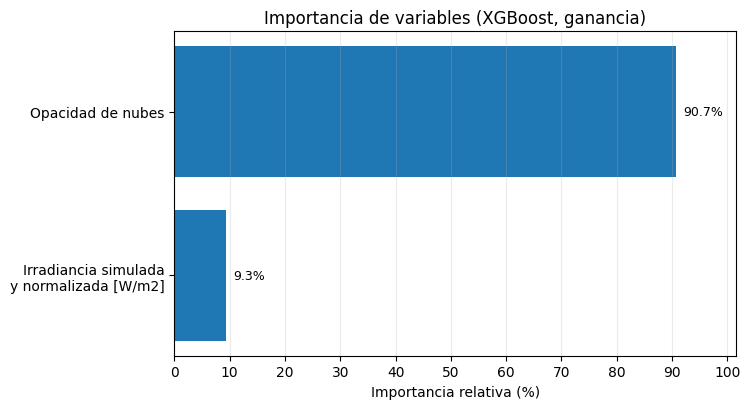

In [30]:
def pretty_feature_name(f: str) -> str:
    if f.startswith("sensor_"):
        s = f.replace("sensor_", "")
        return f"Sensor {s}"

    mapping = {
        "cloud_opacity": "Opacidad de nubes",
        "cloud_cover": "Cobertura nubosa",
        "sim_irradiance_wm2": "Irradiancia simulada\ny normalizada [W/m2]",
        "diffuse_fraction": "Fracción difusa",
    }
    if f in mapping:
        return mapping[f]

    # fallback: snake_case -> "Title case"
    return f.replace("_", " ").strip().capitalize()

def plot_feature_importance(df_importance, top_k=10):
    """
    Plots normalized feature importance (gain %) for the top_k features.
    Expects columns: feature, importance_pct
    """
    dfp = (
        df_importance
        .sort_values("importance_pct", ascending=False)
        .head(top_k)
        .iloc[::-1]
        .copy()
    )

    dfp["feature_label"] = dfp["feature"].astype(str).apply(pretty_feature_name)

    fig, ax = plt.subplots(figsize=(7.6, 4.2))  

    ax.barh(dfp["feature_label"], dfp["importance_pct"])

    ax.set_xlabel("Importancia relativa (%)")
    ax.set_title("Importancia de variables (XGBoost, ganancia)")

    ax.grid(axis="x", alpha=0.25)
    ax.grid(axis="y", visible=False)

    ax.xaxis.set_major_locator(mticker.MultipleLocator(10))

    xmax = float(dfp["importance_pct"].max()) if len(dfp) else 1.0
    ax.set_xlim(0, xmax * 1.12)

    offset = xmax * 0.015
    for y, v in enumerate(dfp["importance_pct"].tolist()):
        ax.text(v + offset, y, f"{v:.1f}%", va="center", fontsize=9)

    plt.tight_layout()
    plt.show()
    
df_imp = pd.DataFrame(meta["feature_importance"]["gain"])
plot_feature_importance(df_imp, top_k=8)

## 8. Visualización de resultados

### 8.1 Series temporales representativas  
A continuación se muestran dos ejemplos representativos del comportamiento del modelo final para un mismo sensor (P1), correspondientes a un día despejado y a un día con alta variabilidad atmosférica. 

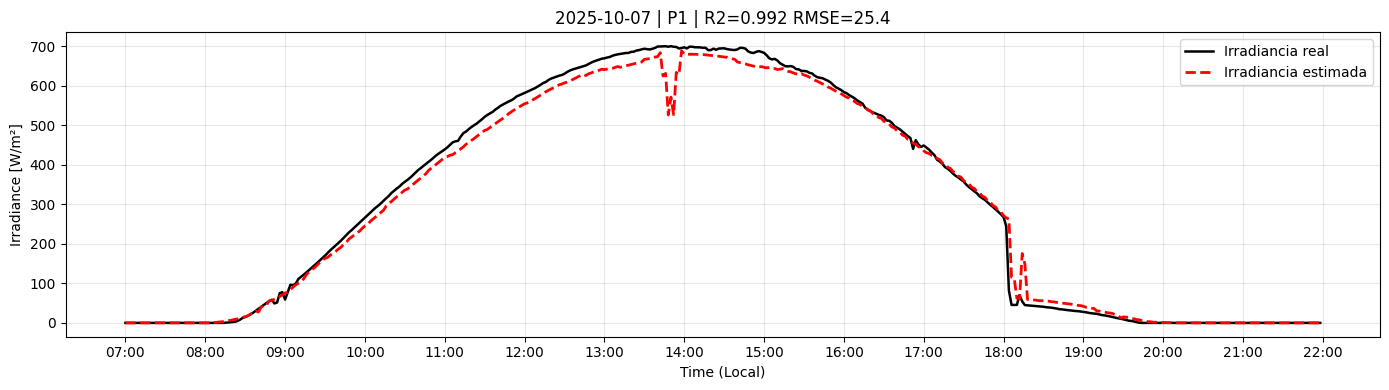

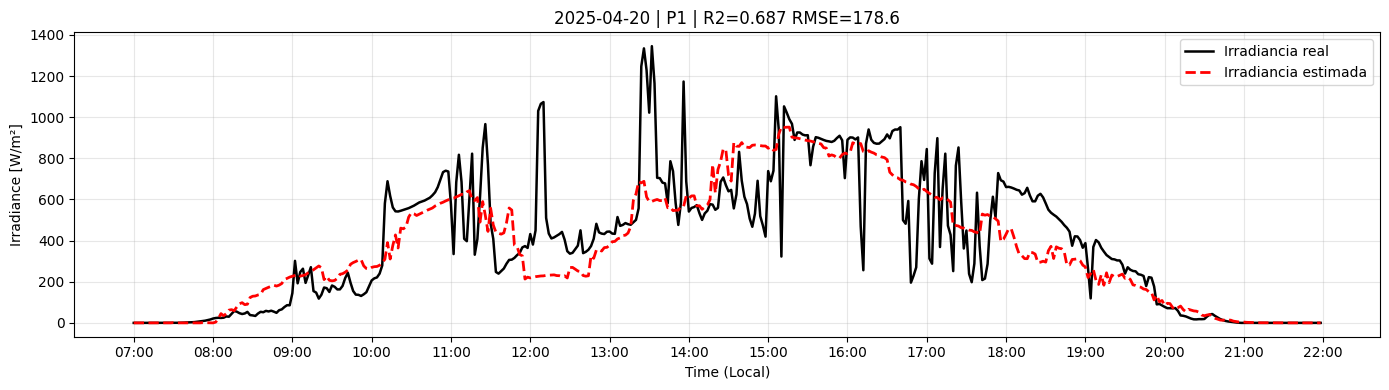

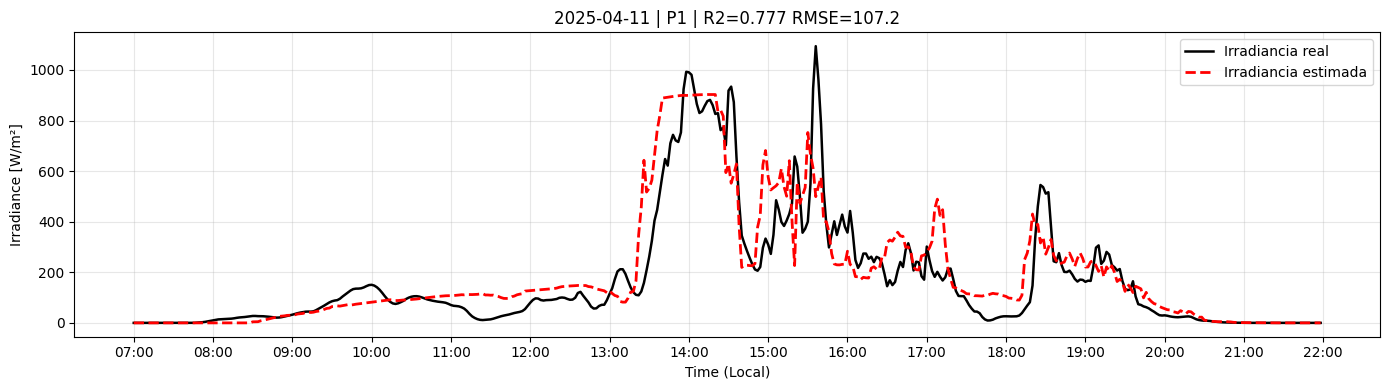

In [31]:
def plot_day_sensor(test_df, model, cfg, day, sensor_name):
    features = build_feature_list(test_df, cfg)
    dd = test_df[test_df["date"] == day].copy()

    # Filter by sensor
    col = f"sensor_{sensor_name}"
    if col in dd.columns:
        dd = dd[dd[col] == 1]

    if dd.empty:
        print("No data for", day, sensor_name)
        return

    _, pred = predict_irradiance(model, dd, dd[features], cfg)
    y = dd["real_irradiance"].values
    m = compute_metrics(y, pred)

    # Plot
    plt.figure(figsize=(14,4))
    plt.plot(dd.index, y, color="black", linewidth=1.8, label="Irradiancia real")
    plt.plot(dd.index, pred, color="red", linestyle="--",linewidth=2.0, label="Irradiancia estimada")
    plt.title(f"{day} | {sensor_name} | R2={m['r2']:.3f} RMSE={m['rmse']:.1f}")
    plt.xlabel("Time (Local)")
    plt.ylabel("Irradiance [W/m²]")
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
    plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval=1))
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_day_sensor(test_df, model, CFG_FINAL, day="2025-10-07", sensor_name="P1")
plot_day_sensor(test_df, model, CFG_FINAL, day="2025-04-20", sensor_name="P1")
plot_day_sensor(test_df, model, CFG_FINAL, day="2025-04-11", sensor_name="P1")